# Aspectos prácticos para la carga de datos masivos.




## Etapa 1: Carga de los datos

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os, shutil

In [ ]:
#classNames = ['cat', 'dog']
#split = ['train[:70%]', 'train[70%:]']
#trainDataset, testDataset = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)

Se nota que al cargar toda la base de datos, estos quedan almacenados en la memoria RAM; así, si la base de datos es muy grande, la RAM puede saturarse. Una alternativa más adecuada es la de almacenar toda la base de datos en el disco duro (que tiene más capacidad) y solo cargar en la RAM los datos que se vayan a utilizar en cada iteración del entrenamiento.

In [4]:
!pip install jovian --upgrade --quiet
!pip install opendatasets --upgrade --quiet
import opendatasets as od

#od.download('https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip')
od.download('https://www.kaggle.com/c/dogs-vs-cats')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hernanvargas1987
Your Kaggle Key: ··········


100%|██████████| 812M/812M [00:23<00:00, 36.1MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [5]:
# Se decomprime la carpeta zip
!unzip /content/dogs-vs-cats/train.zip
#!unzip /content/cats_and_dogs_filtered.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.

In [6]:
original_dataset_dir = '/content/train'
base_dir = '/content'
# Se crea un directorio para el entrenamiento
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# Se crea un directorio para el test
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# Dentro de la carpeta de entrenamiento se geneta una carpeta para cada clase.
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Dentro de la carpeta de prueba se geneta una carpeta para cada clase.
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [7]:
# Se copian 7000 imágenes de gatos en la carpeta de entrenamiento
fnames = ['cat.{}.jpg'.format(i) for i in range(7000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
# Se copian 7000 imágenes de perros en la carpeta de entrenamiento
fnames = ['dog.{}.jpg'.format(i) for i in range(7000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [9]:
# Se copian 3000 imágenes de gatos en la carpeta de prueba
fnames = ['cat.{}.jpg'.format(i) for i in range(7000, 10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [10]:
# Se copian 3000 imágenes de perros en la carpeta de prueba
fnames = ['dog.{}.jpg'.format(i) for i in range(7000, 10000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

## Etapa 2: Procesamiento de los datos

Ahora deben ser cargadas las imágenes a través del módulo ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255) # garantiza que todos los valores
                                                   # estén entre 0 y 1.
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # el directorio donde están las imágenes de train
        target_size= (150, 150), # se hace un reescalado (no tienen el mismo tamaño)
        batch_size= 10, # Cuántas imágenes se toman en iteración
        class_mode='binary') # Clasificacón binaria, cada carpeta dentro de train_dir
                             # es una clase.

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size= (150, 150),
        batch_size= 10,
        class_mode='binary')


Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


## Etapa 3: Definición del modelo por transferencia del aprendizaje


In [13]:
# Se carga el modelo pre-entrenado.
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Se hace que el modelo base no sea entrenable.
base_model.trainable = False

# Se crea un nuevo modelo que se construye sobre el modelo base.
# Input layer is explicitly defined to solve undefined shapes
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)  # Pass the input tensor to the base model

# Se agregan algunas capas para la tarea de aprendizaje. En este punto no se
# suele usar capas convolucionales, solo capas densas y de pooling.
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
# la última capa debe corresponder a la tarea de aprendizaje. En este sentido,
# dado que tenemos un problema de clasificación de 2 clases, usamos una capa
# con una unidad y con activación Sigmoid.
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Ahora se compila, entrena y evalúa el modelo definido por transfer learning.

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1400/1400 ━━━━━━━━━━━━━━━━━━━━ 56s 34ms/step - accuracy: 0.8220 - loss: 0.4288 - val_accuracy: 0.8820 - val_loss: 0.2537
Epoch 2/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.8934 - loss: 0.2493 - val_accuracy: 0.8780 - val_loss: 0.2757
Epoch 3/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.9064 - loss: 0.2221 - val_accuracy: 0.8900 - val_loss: 0.2283
Epoch 4/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.9205 - loss: 0.1948 - val_accuracy: 0.9040 - val_loss: 0.2342
Epoch 5/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9209 - loss: 0.1917 - val_accuracy: 0.9100 - val_loss: 0.2080


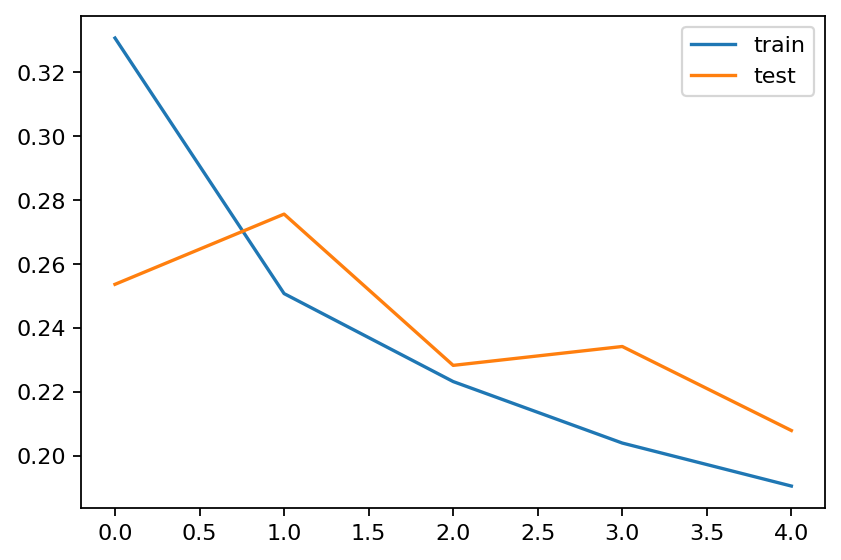

In [18]:
history = model.fit(train_generator, epochs=5, validation_data=test_generator, validation_steps=50)

plt.figure(figsize=(6, 4), dpi=160)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

## 4. Data augmentation

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
        train_dir, # el directorio donde están las imágenes de train
        target_size= (150, 150), # se hace un reexcalado (no tienen el mismo tamaño)
        batch_size= 10, # Cuántas imágenes se toman en iteración
        class_mode='binary') # Clasificacón binaria, cada carpeta dentro de train_dir
                             # es una clase.

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size= (150, 150),
        batch_size= 10,
        class_mode='binary')


Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [21]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
base_model.trainable = False
model_DA = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model_DA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model_DA.fit(train_generator,epochs=5, validation_data=test_generator, validation_steps=50) #tarda alrededor de 30 minutos

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1400/1400 ━━━━━━━━━━━━━━━━━━━━ 124s 86ms/step - accuracy: 0.7799 - loss: 0.5036 - val_accuracy: 0.9000 - val_loss: 0.2732
Epoch 2/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 145s 89ms/step - accuracy: 0.8481 - loss: 0.3376 - val_accuracy: 0.8740 - val_loss: 0.2641
Epoch 3/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 118s 84ms/step - accuracy: 0.8623 - loss: 0.3195 - val_accuracy: 0.9040 - val_loss: 0.2484
Epoch 4/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 139s 82ms/step - accuracy: 0.8672 - loss: 0.3090 - val_accuracy: 0.9000 - val_loss: 0.2457
Epoch 5/5
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 143s 83ms/step - accuracy: 0.8613 - loss: 0.3003 - val_accuracy: 0.9120 - val_loss: 0.2045


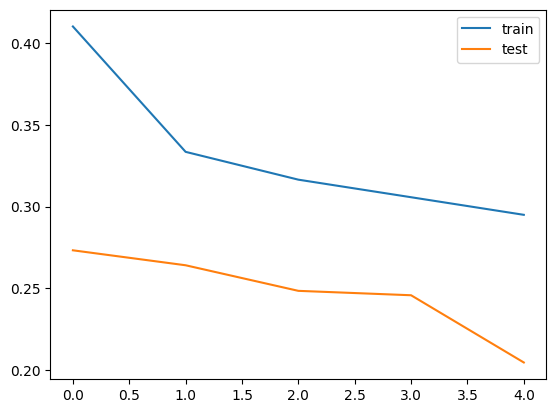

In [23]:
plt.plot(history1.history["loss"], label="train")
plt.plot(history1.history["val_loss"], label="test")
plt.legend()
plt.show()

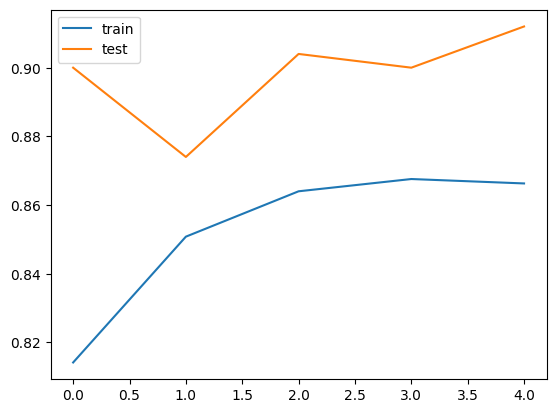

In [24]:
plt.plot(history1.history['accuracy'], label="train")
plt.plot(history1.history['val_accuracy'], label="test")
plt.legend()
plt.show()